<a href="https://colab.research.google.com/github/hafilmr/LearningCodeTrainee/blob/main/Deep%20Learning%20CNN/HAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

We will be looking at how to use concerns for human activity recognition, please note that at this point you have seen all the code and you know where to get the data set.
So if you'd like to complete this exercise yourself, please do. 
So Now, we'll be looking at two versions of this model.

One, CNN that looks purely at the Time series and the combined model that incorporates the tabular
features. So it should be pretty straightforward given what we already know.

## **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
# import some optional layer
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

--2022-02-09 10:00:31--  https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: ‘UCI-HAR.zip’

UCI-HAR.zip         100%[===================>]  58.17M  1016KB/s    in 51s     

2022-02-09 10:01:24 (1.13 MB/s) - ‘UCI-HAR.zip’ saved [60999314/60999314]



In [ ]:
!unzip -nq UCI-HAR.zip

In [ ]:
df = pd.read_csv('UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt', 
                 header=None, 
                 delim_whitespace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 128 entries, 0 to 127
dtypes: float64(128)
memory usage: 7.2 MB


In [ ]:
# Obtain these by inspecting the files
T = 128 #columns
Ntrain = 7352 #entries, range index
Ntest = 2947
D = 9 #Since there are 9 files
K = 6 #Number of classes(1-6)

Define our data loading function, which you've seen. As you recall, this already
returns inputs of size `N x T x D`.
So there is no more work that needs to be done.


In [ ]:
def load_data():
  # Returns:
  # xtrain (Ntrain x T x D), ytrain (Ntrain)
  # xtest (Ntest x T x D), Ytest (Ntest)

  xtrain = np.zeros((Ntrain, T, D))
  xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = [
    'body_acc_x_train.txt',  'body_gyro_x_train.txt',  'total_acc_x_train.txt',
    'body_acc_y_train.txt',  'body_gyro_y_train.txt',  'total_acc_y_train.txt',
    'body_acc_z_train.txt',  'body_gyro_z_train.txt',  'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header = None,
        delim_whitespace=True
    )

    #Ntrain x T array
    x = df.to_numpy()
    xtrain[:, :, d] = x

  # train labels
  ytrain = pd.read_csv(
      f'{ts_file_prefix}y_train.txt', header=None).to_numpy()-1
  ytrain = ytrain.flatten()

  # test data
  ts_filenames = [
    'body_acc_x_test.txt',  'body_gyro_x_test.txt',  'total_acc_x_test.txt',
    'body_acc_y_test.txt',  'body_gyro_y_test.txt',  'total_acc_y_test.txt',
    'body_acc_z_test.txt',  'body_gyro_z_test.txt',  'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header = None,
        delim_whitespace=True
    )

    #Ntrain x T array
    x = df.to_numpy()
    xtest[:, :, d] = x

  # train labels
  ytest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt', header=None).to_numpy()-1
  ytest = ytest.flatten()

  return xtrain, ytrain, xtest, ytest

In [ ]:
xtrain, ytrain, xtest, ytest = load_data()

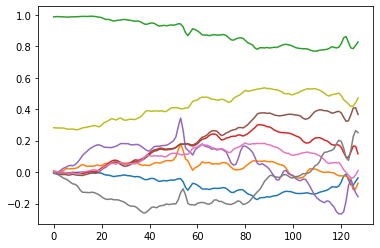

In [ ]:
plt.plot(xtrain[7000, :, :]);

In [ ]:
# CNN
i = Input(shape=(T, D))
# larger images and larger time series -> larger kernel
x = Conv1D(32, 5, activation='relu')(i) #kernel size of 5 and 32 feature maps 
x = MaxPooling1D(3)(x) #pooling size 3
x = Conv1D(64, 3, activation='relu')(x) #declare Conv1d with size of kernel 3 and 64 feature maps
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d (Conv1D)             (None, 124, 32)           1472      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 17, 128)           24704 

Note that sometimes the values don't divide evenly. Now, the menu details aren't really a concern for most people, but sometimes students ask, well,
what happens in this case?

If you want a definitive answer to this question, I'd encourage you to look at the source code to see how those cases are handled.
For example, it might ignore the first of the final pixel or something of that nature.

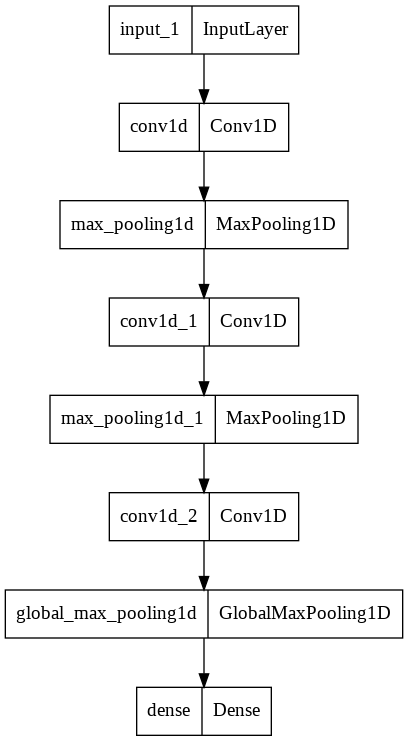

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True
)

In [ ]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
r = model.fit(
    xtrain,
    ytrain,
    epochs=15,
    callbacks=[check_point],
    validation_data=(xtest, ytest)
)

Epoch 1/15
230/230 [==============================] - 5s 16ms/step - loss: 0.4047 - accuracy: 0.8671 - val_loss: 0.2427 - val_accuracy: 0.8985
Epoch 2/15
230/230 [==============================] - 4s 15ms/step - loss: 0.1197 - accuracy: 0.9535 - val_loss: 0.2618 - val_accuracy: 0.9141
Epoch 3/15
230/230 [==============================] - 3s 14ms/step - loss: 0.1069 - accuracy: 0.9554 - val_loss: 0.2226 - val_accuracy: 0.9145
Epoch 4/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0973 - accuracy: 0.9595 - val_loss: 0.2101 - val_accuracy: 0.9237
Epoch 5/15
230/230 [==============================] - 4s 16ms/step - loss: 0.0921 - accuracy: 0.9621 - val_loss: 0.3111 - val_accuracy: 0.9057
Epoch 6/15
230/230 [==============================] - 3s 15ms/step - loss: 0.0846 - accuracy: 0.9623 - val_loss: 0.2209 - val_accuracy: 0.9125
Epoch 7/15
230/230 [==============================] - 4s 16ms/step - loss: 0.0790 - accuracy: 0.9663 - val_loss: 0.2928 - val_accuracy: 0.9070

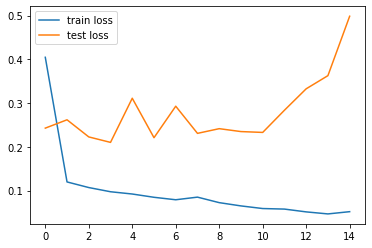

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

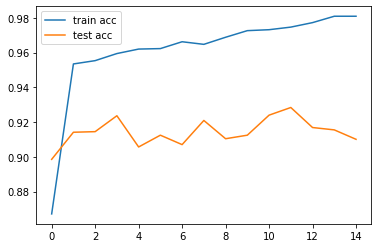

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [ ]:
# load best_model
best_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
# make predictions
ptest = best_model.predict(xtest)

In [ ]:
# evaluate
np.mean(np.argmax(ptest, axis=1) == ytest)

0.9284017645062775

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
def load_features():
  # Returns:
  # x_train (Ntrain x D)
  # x_test (Ntest x D)

  # train data
  df = pd.read_csv(
      'UCI HAR Dataset/train/X_train.txt',
      header=None,
      delim_whitespace=True
  )

  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv(
      'UCI HAR Dataset/test/X_test.txt',
      header=None,
      delim_whitespace=True
  )

  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [ ]:
feat_train, feat_test = load_features()

In [ ]:
D_feat = feat_train.shape[1]

Next step is to build our combined model. So this has three parts.

* The first part is the convolution and pooling part, which is the same as before.So that's where the time series passes through.
* The second part is the ANN part, which is where the tabular features is passed through. So at this point, both X and x2, to represent different feature vectors from different sources.
* The third part is to combine these two feature vectors together and apply one final dense layer. As you recall, it's possible to add more dense layers anywhere you see a dense layer.

So please try that if you think it might help.

In [ ]:
# Combined Model

# CNN
# First Part
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# ANN
# Second Part
i2 = Input(shape=(D_feat, ))
x2 = Dense(64, activation='relu')(i2)

# Third Part
x = Concatenate()([x, x2])
x = Dense(K)(x)
model = Model([i, i2], x)

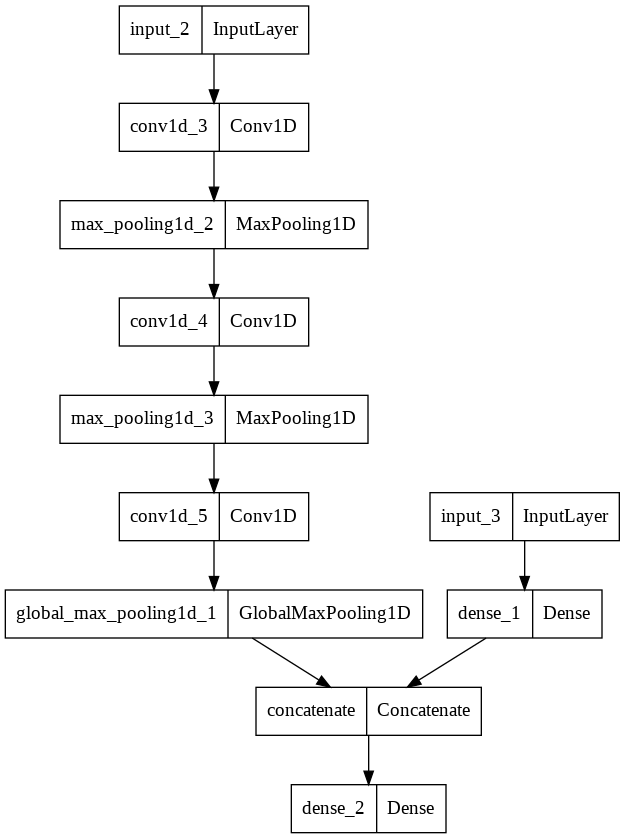

In [ ]:
tf.keras.utils.plot_model(model)

**Create Check point**

In [ ]:
check_point3 = ModelCheckpoint(
    'best_model_combined.h5', monitor='val_accuracy', save_best_only=True
)

In [ ]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
r = model.fit(
    [xtrain, feat_train],
    ytrain,
    epochs=15,
    callbacks=[check_point3],
    validation_data=([xtest, feat_test], ytest)
)

Epoch 1/15
230/230 [==============================] - 5s 17ms/step - loss: 0.2221 - accuracy: 0.9189 - val_loss: 0.1533 - val_accuracy: 0.9393
Epoch 2/15
230/230 [==============================] - 4s 16ms/step - loss: 0.0733 - accuracy: 0.9712 - val_loss: 0.1574 - val_accuracy: 0.9488
Epoch 3/15
230/230 [==============================] - 4s 17ms/step - loss: 0.0492 - accuracy: 0.9803 - val_loss: 0.1192 - val_accuracy: 0.9583
Epoch 4/15
230/230 [==============================] - 4s 17ms/step - loss: 0.0423 - accuracy: 0.9838 - val_loss: 0.1383 - val_accuracy: 0.9559
Epoch 5/15
230/230 [==============================] - 4s 16ms/step - loss: 0.0370 - accuracy: 0.9872 - val_loss: 0.1275 - val_accuracy: 0.9566
Epoch 6/15
230/230 [==============================] - 4s 16ms/step - loss: 0.0347 - accuracy: 0.9859 - val_loss: 0.1263 - val_accuracy: 0.9596
Epoch 7/15
230/230 [==============================] - 4s 16ms/step - loss: 0.0296 - accuracy: 0.9887 - val_loss: 0.1608 - val_accuracy: 0.9518

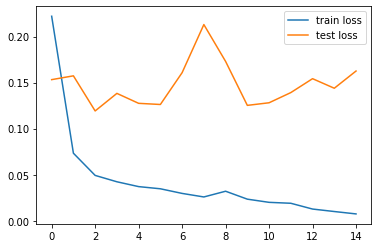

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

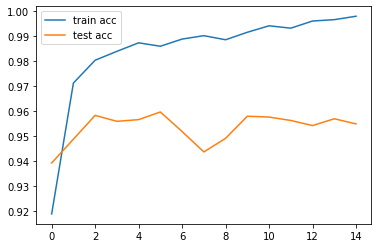

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [ ]:
best_model = tf.keras.models.load_model('best_model_combined.h5')

In [ ]:
# make prediction
ptest = best_model.predict([xtest, feat_test])

In [ ]:
# evaluate
np.mean(np.argmax(ptest, axis=1) == ytest)

0.9596199524940617